# Turnover Project

**Objetivo do Projeto**
Desenvolver um modelo de análise preditiva para identificar funcionários com maior probabilidade de sair da empresa nos próximos meses, focando nos seguintes pontos:
- Identificar os principais fatores de desligamento (voluntário e involuntário), considerando variáveis como desempenho, satisfação, engajamento e características demográficas.
- Criar um modelo preditivo de turnover para identificar o risco de saída de funcionários.
- Recomendar estratégias de retenção direcionadas para grupos específicos de funcionários com alto risco de desligamento, visando melhorar o engajamento e a satisfação no trabalho.


**Questões a Serem Respondidas:**
- Quais são os fatores mais críticos para o turnover? - Analisar se variáveis como engajamento, desempenho, satisfação e absenteísmo são correlacionadas com o turnover.
- Quais tipos de desligamento são mais comuns? - Identificar se a maioria dos desligamentos é voluntária ou involuntária e se há diferenciação nos fatores que levam a cada tipo de desligamento.
- Quais departamentos e posições apresentam maiores taxas de turnover? - Avaliar se existem áreas ou cargos onde a taxa de desligamento é mais alta para entender se há necessidade de políticas específicas para essas áreas.
- Quais são os impactos do desempenho, satisfação e engajamento no turnover? - Avaliar se os funcionários com baixo desempenho, baixa satisfação ou engajamento têm maior probabilidade de sair da empresa.
- Como a retenção pode ser melhorada? - Com base nos fatores descobertos, sugerir políticas e práticas para aumentar a retenção.

## Data Dictionary


| Feature                   | Description                                                                      | DataType |
|---------------------------|----------------------------------------------------------------------------------|----------|
| Employee Name             | Employee’s full name                                                             | Text     |
| EmpID                     | Employee ID unique to each employee                                              | Text     |
| MarriedID                 | Is the person married (1 or 0 for yes or no)                                     | Binary   |
| MaritalStatusID           | Marital status code that matches the text field MaritalDesc                      | Integer  |
| EmpStatusID               | Employment status code that matches text field EmploymentStatus                  | Integer  |
| DeptID                    | Department ID code that matches the department the employee works in             | Integer  |
| PerfScoreID               | Performance Score code that matches the employee’s most recent performance score | Integer  |
| FromDiversityJobFairID    | Was the employee sourced from the Diversity job fair? 1 or 0 for yes or no       | Binary   |
| Salary                    | The person’s yearly salary in U.S. Dollars                                       | Float    |
| Termd                     | Has this employee been terminated - 1 or 0                                       | Binary   |
| PositionID                | An integer indicating the person’s position                                      | Integer  |
| Position                  | The text name/title of the position the person has                               | Text     |
| State                     | The state that the person lives in                                               | Text     |
| Zip                       | The zip code for the employee                                                    | Text     |
| DOB                       | Date of Birth for the employee                                                   | Date     |
| Sex                       | Sex - M or F                                                                     | Text     |
| MaritalDesc               | The marital status of the person (divorced, single, widowed, separated, etc)     | Text     |
| CitizenDesc               | Label for whether the person is a Citizen or Eligible NonCitizen                 | Text     |
| HispanicLatino            | Yes or No field for whether the employee is Hispanic/Latino                      | Text     |
| RaceDesc                  | Description/text of the race the person identifies with                          | Text     |
| DateofHire                | Date the person was hired                                                        | Date     |
| DateofTermination         | Date the person was terminated, only populated if Termd = 1                      | Date     |
| TermReason                | A text reason/description for why the person was terminated                      | Text     |
| EmploymentStatus          | Description/category of the person’s employment status, "Active" if full-time    | Text     |
| Department                | Name of the department that the person works in                                  | Text     |
| ManagerName               | The name of the person’s immediate manager                                       | Text     |
| ManagerID                 | A unique identifier for each manager                                             | Integer  |
| RecruitmentSource         | The name of the recruitment source where the employee was recruited from         | Text     |
| PerformanceScore          | Performance Score text/category (Fully Meets, Partially Meets, PIP, Exceeds)     | Text     |
| EngagementSurvey          | Results from the last engagement survey, managed by an external partner          | Float    |
| EmpSatisfaction           | Satisfaction score between 1 and 5 from a recent employee satisfaction survey    | Integer  |
| SpecialProjectsCount      | Number of special projects worked on by employee in last 6 months                | Integer  |
| LastPerformanceReviewDate | The most recent date of the person’s last performance review                     | Date     |
| DaysLateLast30            | Number of times the employee was late to work in the last 30 days                | Integer  |
| Absences                  | Number of times the employee was absent from work                                | Integer  |


# 0.0. IMPORTS

In [1]:
# Bibliotecas padrão
import numpy as np
import pandas as pd
from datetime import datetime
from PIL import Image

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e manipulação de dados
import inflection
from sklearn import preprocessing as pp

# Modelagem
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Fine tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Balanceamento de classes
from imblearn.over_sampling import SMOTE


## 0.1. Functions

In [2]:
def statistical_summary(df):
    # Seleciona apenas as colunas numéricas
    numeric_df = df.select_dtypes(include=['number'])
    
    # Calcula as estatísticas
    summary_df = pd.DataFrame({
        "Min": numeric_df.min(),
        "Max": numeric_df.max(),
        "Range": numeric_df.max() - numeric_df.min(),
        "Mean": numeric_df.mean(),
        "Median": numeric_df.median(),
        "Std Dev": numeric_df.std(),
        "Skew": numeric_df.skew(),
        "Kurtosis": numeric_df.kurt()
    })
    
    return summary_df

## 0.2. Loading Data

In [3]:
data = pd.read_csv('../data/HRDataset_v14.csv')

# 1.0. DESCRIÇÃO DOS DADOS

In [37]:
df1 = data.copy()

## 1.1. Tamanho dos Dados

In [38]:
print(f'Numero de linhas: {df1.shape[0]}')
print(f'Numero de colunas: {df1.shape[1]}')

Numero de linhas: 311
Numero de colunas: 36


## 1.2. Nome das Colunas

In [39]:
# Converte cada coluna para snake_case usando a função inflection.underscore
df1.columns = [inflection.underscore(col) for col in df1.columns]

# Exibe as novas colunas
print(df1.columns)

Index(['employee_name', 'emp_id', 'married_id', 'marital_status_id',
       'gender_id', 'emp_status_id', 'dept_id', 'perf_score_id',
       'from_diversity_job_fair_id', 'salary', 'termd', 'position_id',
       'position', 'state', 'zip', 'dob', 'sex', 'marital_desc',
       'citizen_desc', 'hispanic_latino', 'race_desc', 'dateof_hire',
       'dateof_termination', 'term_reason', 'employment_status', 'department',
       'manager_name', 'manager_id', 'recruitment_source', 'performance_score',
       'engagement_survey', 'emp_satisfaction', 'special_projects_count',
       'last_performance_review_date', 'days_late_last30', 'absences'],
      dtype='object')


## 1.3. Tipo dos Dados

In [40]:
df1['dateof_hire'] = pd.to_datetime(df1['dateof_hire'])
df1['dateof_termination'] = pd.to_datetime(df1['dateof_termination'])
df1['last_performance_review_date'] = pd.to_datetime(df1['last_performance_review_date'])

In [41]:
df1.dtypes

employee_name                           object
emp_id                                   int64
married_id                               int64
marital_status_id                        int64
gender_id                                int64
emp_status_id                            int64
dept_id                                  int64
perf_score_id                            int64
from_diversity_job_fair_id               int64
salary                                   int64
termd                                    int64
position_id                              int64
position                                object
state                                   object
zip                                      int64
dob                                     object
sex                                     object
marital_desc                            object
citizen_desc                            object
hispanic_latino                         object
race_desc                               object
dateof_hire  

## 1.4. Dados Faltantes

In [42]:
null_columns = df1.isnull().sum()
null_columns = null_columns[null_columns > 0]
print(null_columns)

dateof_termination    207
manager_id              8
dtype: int64


In [43]:
df1['manager_id'].fillna(0, inplace=True)

- Dateoftermination: 207 não tiveram os contratos encerrados (substitui pela data atual)
- ManagerID: 8 estão faltando ID. Considerei que eles não tem um gerente e coloquei 0

## 1.5 Dados Inconsistentes

In [44]:
# Remover espaços extras e padronizar para minúsculas
df1['position'] = df1['position'].str.strip().str.lower()

## 1.6. Análise Estatística

In [45]:
statistical_summary(df1)

,Min,Max,Range,Mean,Median,Std Dev,Skew,Kurtosis
emp_id,10001.00,10311.0,310.00,10156.000000,10156.00,89.922189,0.000000,-1.200000
married_id,0.00,1.0,1.00,0.398714,0.00,0.490423,0.415730,-1.839037
marital_status_id,0.00,4.0,4.00,0.810289,1.00,0.943239,1.408602,2.053512
gender_id,0.00,1.0,1.00,0.434084,0.00,0.496435,0.267278,-1.941087
emp_status_id,1.00,5.0,4.00,2.392283,1.00,1.794383,0.631944,-1.488610
dept_id,1.00,6.0,5.00,4.610932,5.00,1.083487,-1.536392,2.241434
perf_score_id,1.00,4.0,3.00,2.977492,3.00,0.587072,-1.248091,4.049610
from_diversity_job_fair_id,0.00,1.0,1.00,0.093248,0.00,0.291248,2.811250,5.941296
salary,45046.00,250000.0,204954.00,69020.684887,62810.00,25156.636930,3.306181,15.452149
termd,0.00,1.0,1.00,0.334405,0.00,0.472542,0.705404,-1.512171


# 2.0. CRIAÇÃO DE FEATURES

In [60]:
df2 = df1.copy()

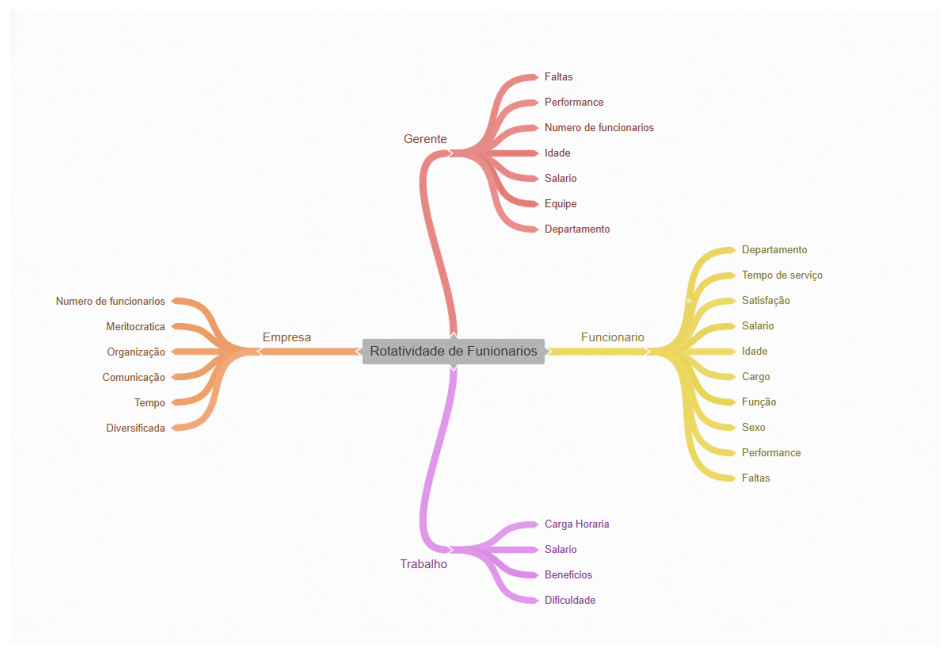

In [61]:
image_path = "../img/mindmap.png"
image = Image.open(image_path)

plt.figure(figsize=(12, 10))
plt.imshow(image)
plt.axis('off')  # Oculta os eixos
plt.show()


## 2.1. Mapa Mental de Hipóteses

**FUNCIONARIO**
- **Funcionarios com mais tempo de serviço tendem a ter menos turnover**
- **Funcionarios que estão satisfeitos com a empresa tendem a ter menos turnover**
- Funcionarios mais velhos tendem a ter menos turnover
- **Funcionarios com salario menor tendem a ter mais turnover**
- **Funcionarios de cargos mais elevados tendem a ter menos turnovers**
- **Funcionarios com mais faltas tendem a ter mais turnovers**
- **Funcionarios casados tendem a ter menos turnover**
- **Funcionarios com melhores performances tendem a ter menos turnovers**
- **Funcionarios mais engajados na empresa tendem a ter menos turnovers**
- Funcionarios com mais atrasos tendem a ter mais turnovers
- **Funcionarios avaliados recentemente tem menos turnover**

**TRABALHO**
- Trabalho com cargas horarias mais elevadas tendem a ter mais turnovers
- Trabalho com menos beneficios tendem a ter mais turnover
- **Trabalho mais dificeis tendem a ter mais turnover**
- **Departamentos diferentes tem o mesmo numero de turnovers**

**GERENTE**
- Gerentes com menos comunicação com a equipe geram mais turnovers
- Gerentes com menor performance tendem a ter mais turnovers
- **Gerentes com mais funcionarios na equipe tendem a ter mais turnovers**

**EMPRESA**
- **Empresas com menos diversidade de pessoas tendem a ter mais turnovers**
- Empresas menos comunicativa com os funcionarios tendem a ter mais turnovers
- Empresas menos organizadas tendem a ter mais turnovers
- Empresas mais meritocraticas tendem a ter menos turnovers



## 2.2. Novas Features

### 2.2.1 Tempo de serviço

In [62]:
df1.dateof_termination.max()

Timestamp('2018-11-10 00:00:00')

In [63]:
# Converte as datas para o formato datetime
df2['dateof_hire'] = pd.to_datetime(df2['dateof_hire'])
df2['dateof_termination'] = pd.to_datetime(df2['dateof_termination'], errors='coerce')  # Usa 'NaT' para valores ausentes

# Define a data fixa para janeiro de 2020
current_date = pd.to_datetime('2020-01-01')

# Substitui NaT em 'DateofTermination' pela data atual fixa para quem está ativo
df2['dateof_termination'] = df2['dateof_termination'].fillna(current_date)

# Calcula o tempo de serviço em anos
df2['service_time'] = ((df2['dateof_termination'] - df2['dateof_hire']).dt.days / 365).round(1)


### 2.2.2. Tempo desde a ultima avalição de desempenho

In [64]:
# Converte as datas para o formato datetime
df2['last_performance_review_date'] = pd.to_datetime(df2['last_performance_review_date'])


# Calcula o tempo  em anos
df2['time_since_last_review'] = ((df2['dateof_termination'] - df2['last_performance_review_date']).dt.days / 365).round(1)


### 2.2.3. Idade no momento da contratação
**Muitas datas de nascimento erradas**

In [16]:
# Converte as datas para o formato datetime
#df2['dob'] = pd.to_datetime(df2['dob'])

# Calcula a idade no momento da contratação
#df2['hired_age'] = ((df2['dateof_hire'] - df2['dob']).dt.days / 365).round(1)

### 2.2.4. Diferença Salarial com media do departamento

In [65]:
mean_salary_dept = df2.groupby('dept_id')['salary'].transform('mean')

df2['salary_from_mean'] = (df2['salary'] - mean_salary_dept).round(2)

### 2.2.5 Tamanho da equipe do gerente

In [66]:
manager_workload = df2.groupby('manager_id')['emp_id'].transform('count')

df2['manager_workload'] = manager_workload

### 2.2.6. Performance e Satisfação Gerente

# 3.0. SELEÇÃO DE LINHAS E COLUNAS

In [67]:
df3 = df2.copy()

In [68]:
cols_drop = ['employee_name', 'state', 'zip', 'dob', 'dateof_hire', 'dateof_termination', 'manager_name', 'last_performance_review_date' ]

df3.drop(columns=cols_drop, inplace=True)

# 4.0. ANÁLISE EXPLORATÓRIA

In [69]:
df4 = df3.copy()

## 4.1. Análise Univariada

<Figure size 1200x800 with 0 Axes>

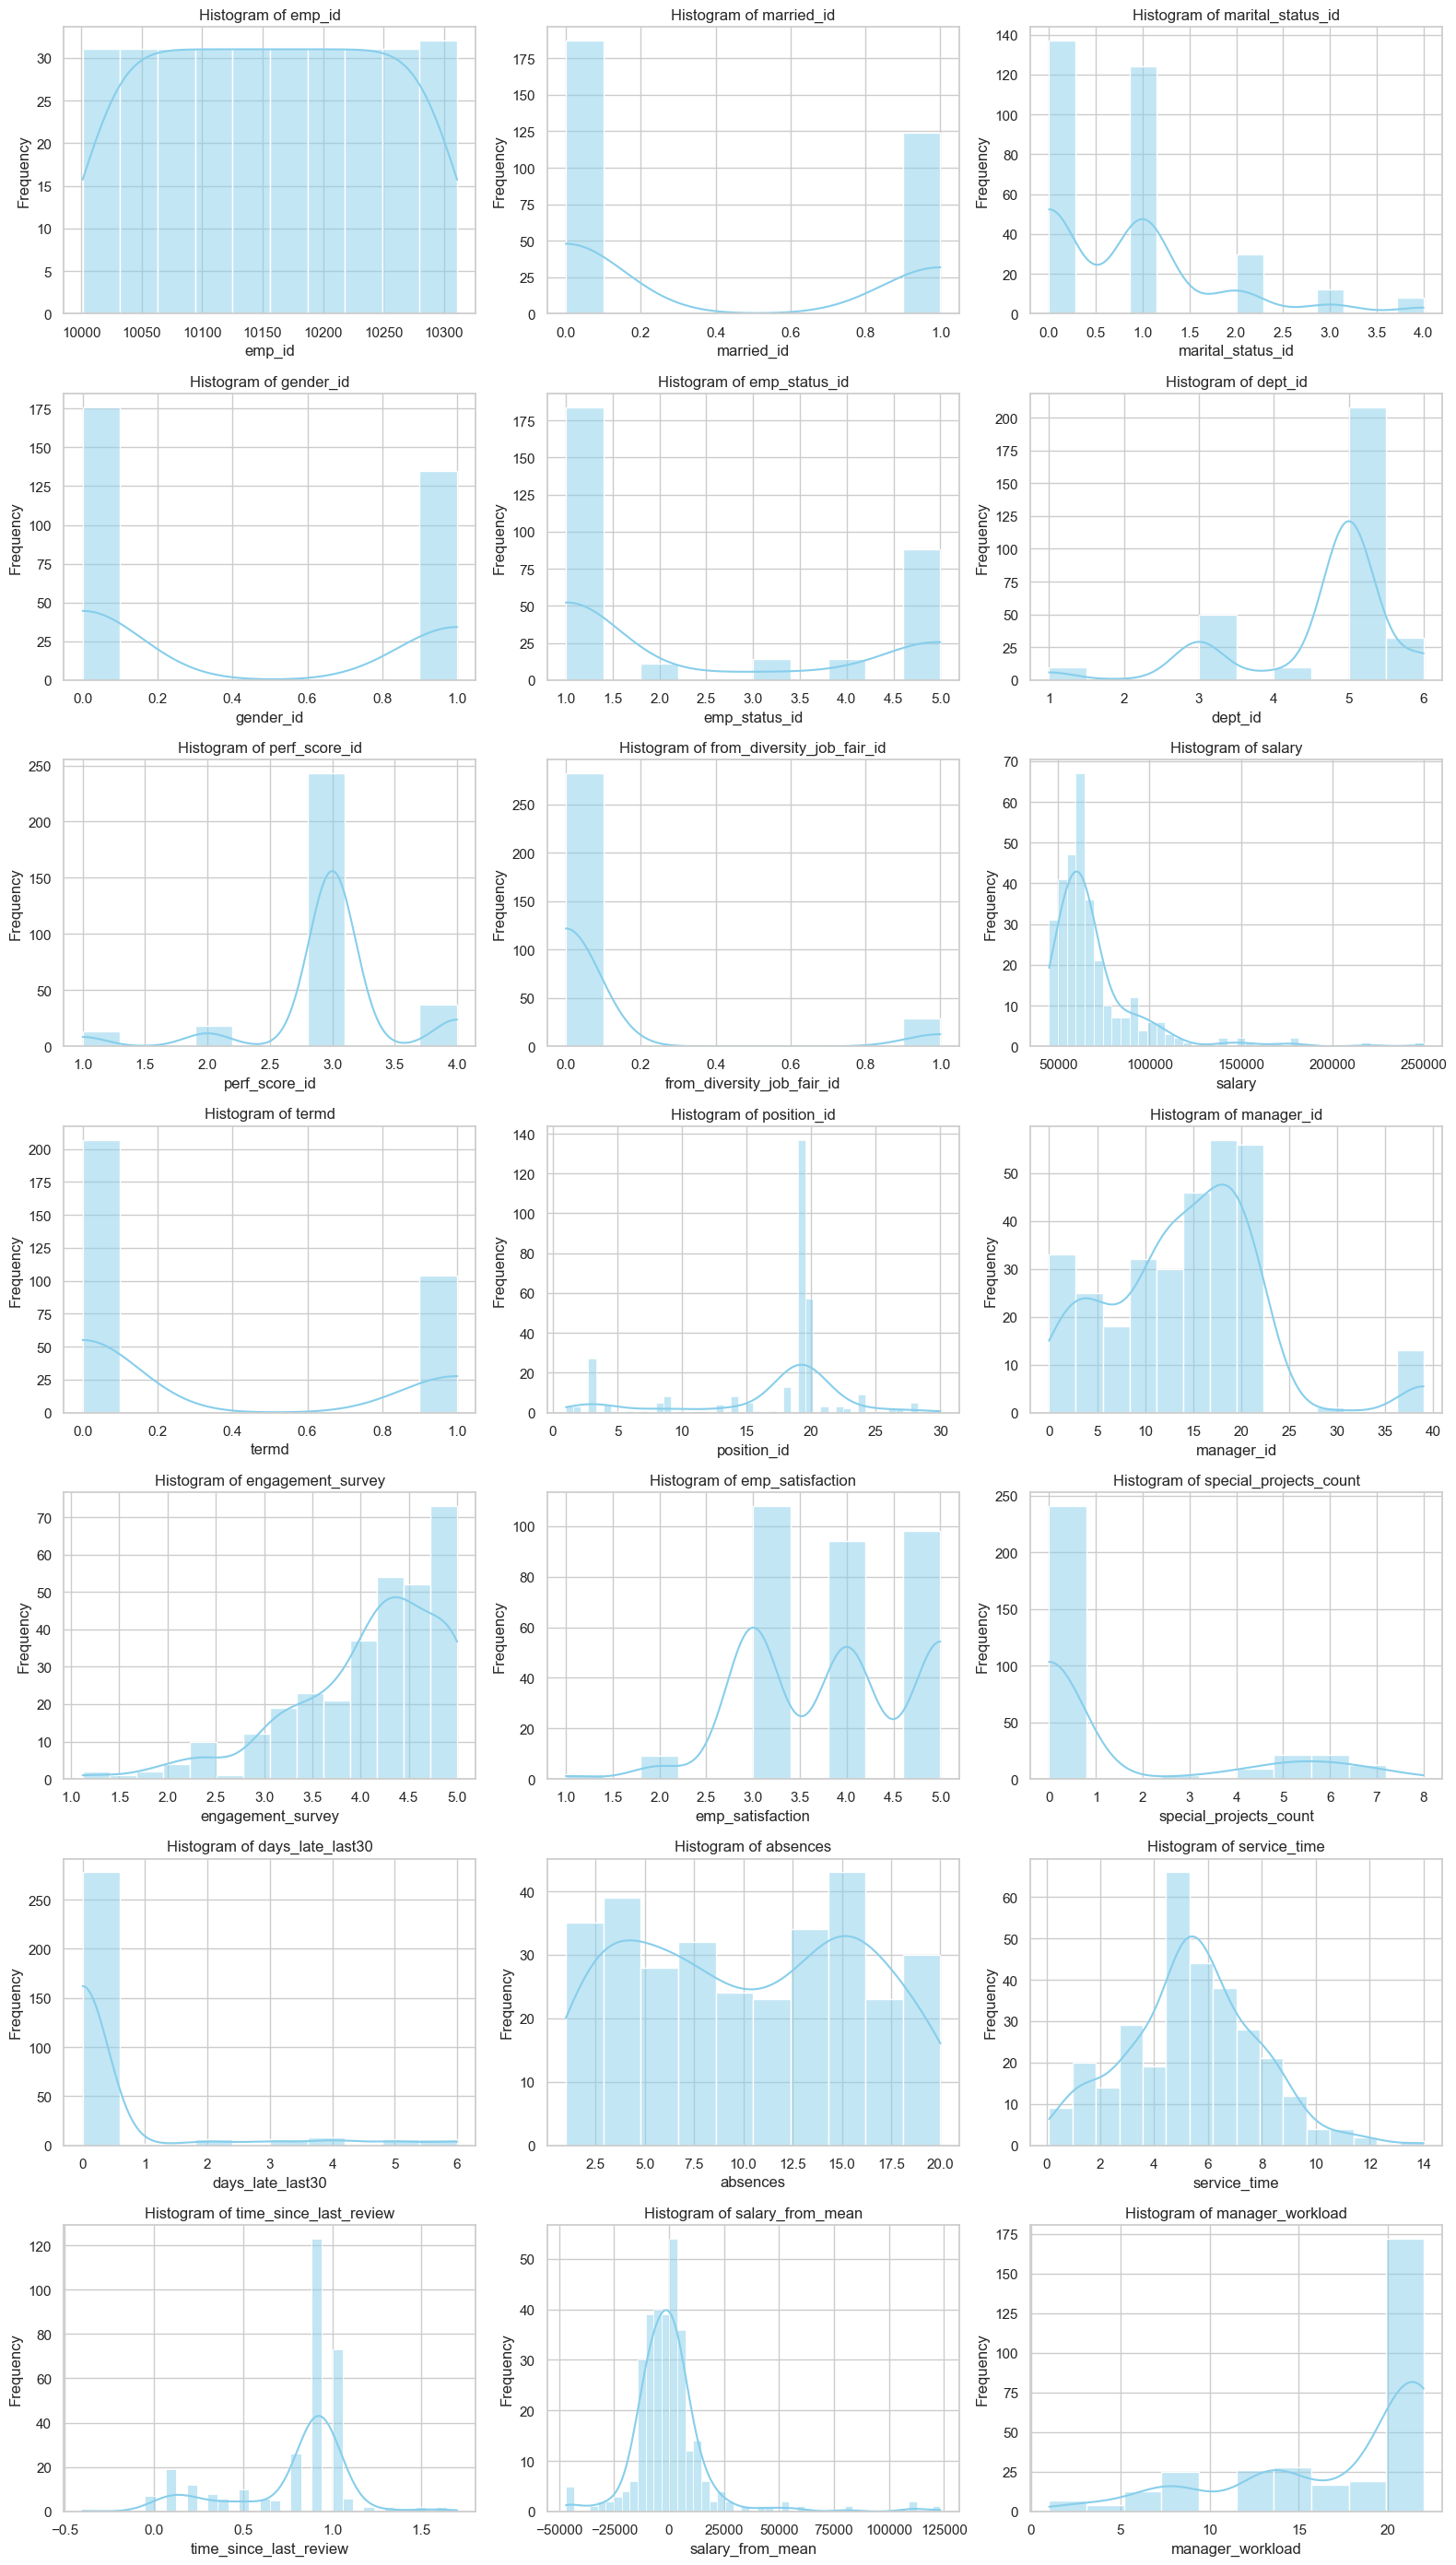

In [70]:
# Configurações para os gráficos
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Loop para percorrer cada variável numérica e plotar histogramas
numeric_columns = df4.select_dtypes(include=['float64', 'int64']).columns  # Seleciona apenas colunas numéricas

# Definindo o layout dos gráficos
n_cols = 3  # Número de gráficos por linha
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Número de linhas necessárias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))  # Ajusta o tamanho da figura

# Evita erro se houver menos gráficos que espaços criados
axes = axes.flatten()  # Flatten a lista para fácil acesso

# Plotando cada variável numérica em um histograma
for i, col in enumerate(numeric_columns):
    sns.histplot(df4[col].dropna(), kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

<Figure size 1200x800 with 0 Axes>

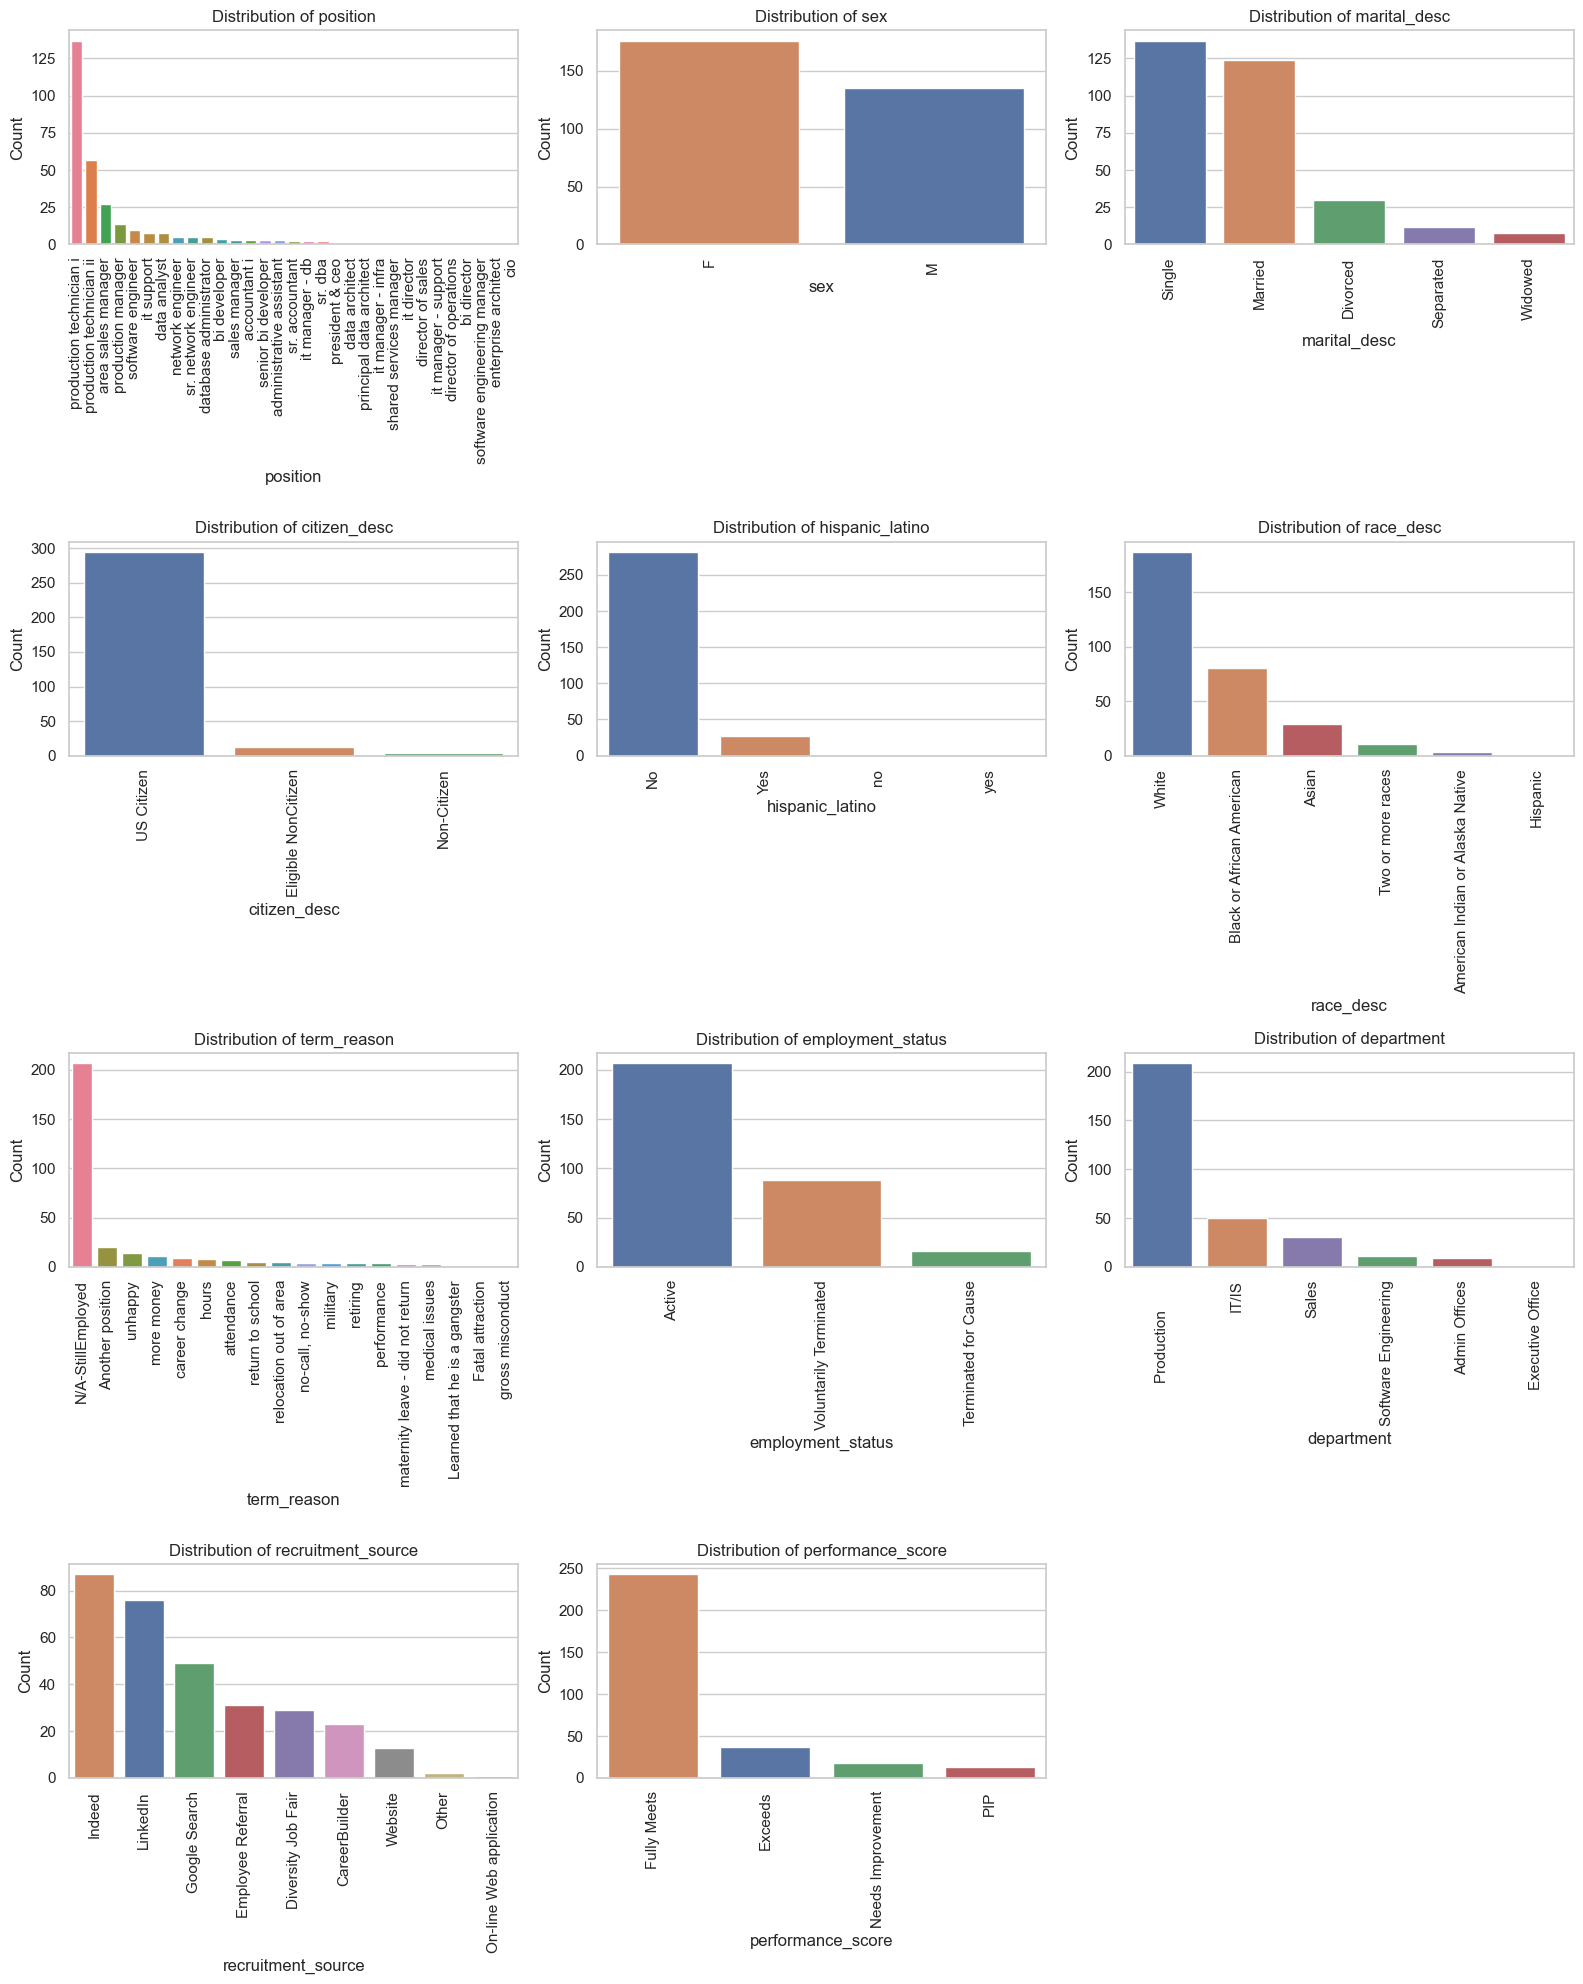

In [71]:
# Configurações de estilo e tamanho dos gráficos
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Selecionando apenas as colunas categóricas
categorical_columns = df4.select_dtypes(include=['object', 'category']).columns

# Definindo o layout para os gráficos de barras
n_cols = 3  # Número de gráficos por linha
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # Número de linhas necessárias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))  # Ajusta o tamanho da figura
axes = axes.flatten()  # Flatten para acesso direto aos eixos

# Loop para criar gráficos de barras para cada variável categórica
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df4, x=col, ax=axes[i], hue=col, legend=False, order=df4[col].value_counts().index);
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)  # Rotaciona os labels para melhorar legibilidade

# Remove subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout();
plt.show();

## 4.2. Análise Bivariada

### 4.2.1. Funcionarios com mais tempo de serviço tendem a ter menos turnover
Existe uma boa diferença entre funcionários com mais tempo de serviço em relação ao turnover

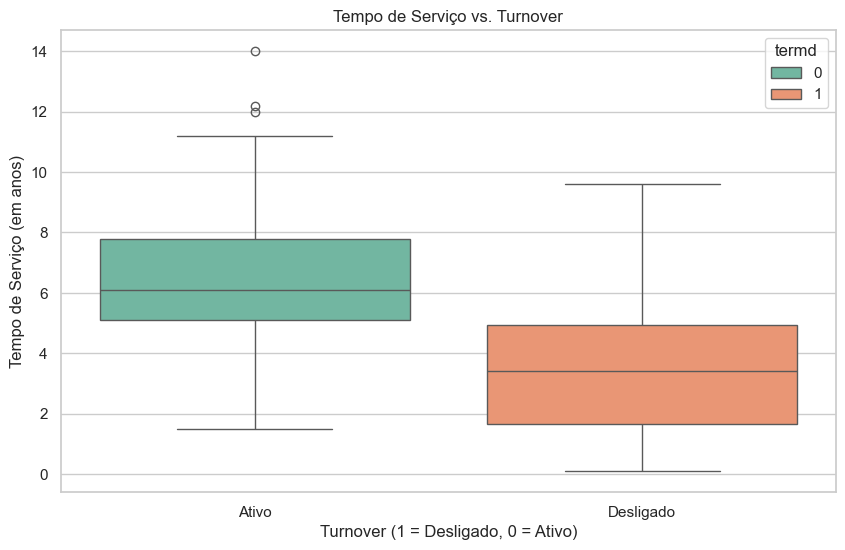

           mean  median       std
termd                            
0      6.363768     6.1  1.953387
1      3.465385     3.4  2.021764
Correlação entre tempo de serviço e turnover: -0.57


In [72]:
plt.figure(figsize=(10, 6));

# Comparação do tempo de serviço entre funcionários que foram desligados e os que não foram
sns.boxplot(data=df4, x='termd', y='service_time', hue='termd', palette="Set2");
plt.title("Tempo de Serviço vs. Turnover");
plt.xlabel("Turnover (1 = Desligado, 0 = Ativo)");
plt.ylabel("Tempo de Serviço (em anos)");
plt.xticks([0, 1], ['Ativo', 'Desligado']);
plt.show();

# Calcular a média e mediana de tempo de serviço por tipo de turnover
aux = df4.groupby('termd')['service_time'].agg(['mean', 'median', 'std'])
print(aux)

# Calcular correlação entre tempo de serviço e turnover
correlation = df4['service_time'].corr(df4['termd'])
print(f'Correlação entre tempo de serviço e turnover: {correlation:.2f}')

### 4.2.2. Funcionarios que estão satisfeitos com a empresa tendem a ter menos turnover
Não parece ter diferença entre os que estão satisfeitos em relação ao turnover. 
1. Os funcionarios respondem querendo agradar, ja que a mediana de satisfação é 4

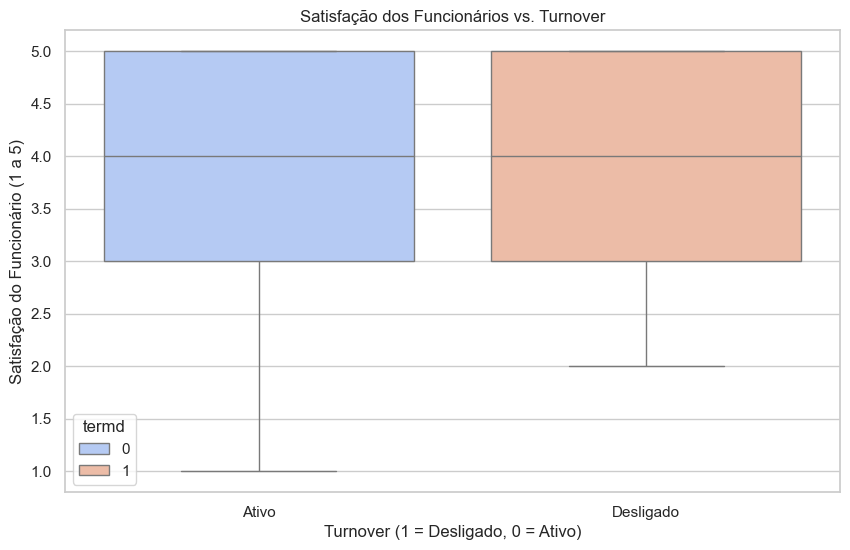

           mean  median       std
termd                            
0      3.893720     4.0  0.933887
1      3.884615     4.0  0.862461
Correlação entre satisfação dos funcionários e turnover: -0.00


In [73]:
plt.figure(figsize=(10, 6))

# Boxplot para comparar a satisfação dos funcionários entre os grupos de turnover
sns.boxplot(data=df4, x='termd', y='emp_satisfaction', hue='termd', palette="coolwarm")
plt.title("Satisfação dos Funcionários vs. Turnover")
plt.xlabel("Turnover (1 = Desligado, 0 = Ativo)")
plt.ylabel("Satisfação do Funcionário (1 a 5)")
plt.xticks([0, 1], ['Ativo', 'Desligado'])
plt.show()

# Calcular a média e mediana satisfação dos funcionários por tipo de turnover
aux = df4.groupby('termd')['emp_satisfaction'].agg(['mean', 'median', 'std'])
print(aux)

# Calcular correlação entre satisfação dos funcionários e turnover
correlation = df4['emp_satisfaction'].corr(df4['termd'])
print(f'Correlação entre satisfação dos funcionários e turnover: {correlation:.2f}')

### 4.2.3. Funcionarios com salario menor tendem a ter mais turnover
Salario não parece ser um fator importante para o turnover

               mean   median           std
termd                                     
0      70694.033816  63051.0  27739.416425
1      65690.076923  60547.0  18679.799457
Correlação entre salario e turnover: -0.09
             mean   median           std
termd                                   
0     -159.766522 -1760.79  20554.587379
1      317.994519   -68.79  11013.729310
Correlação entre Diferença Salarial em relação à Média do Departamento e turnover: 0.01


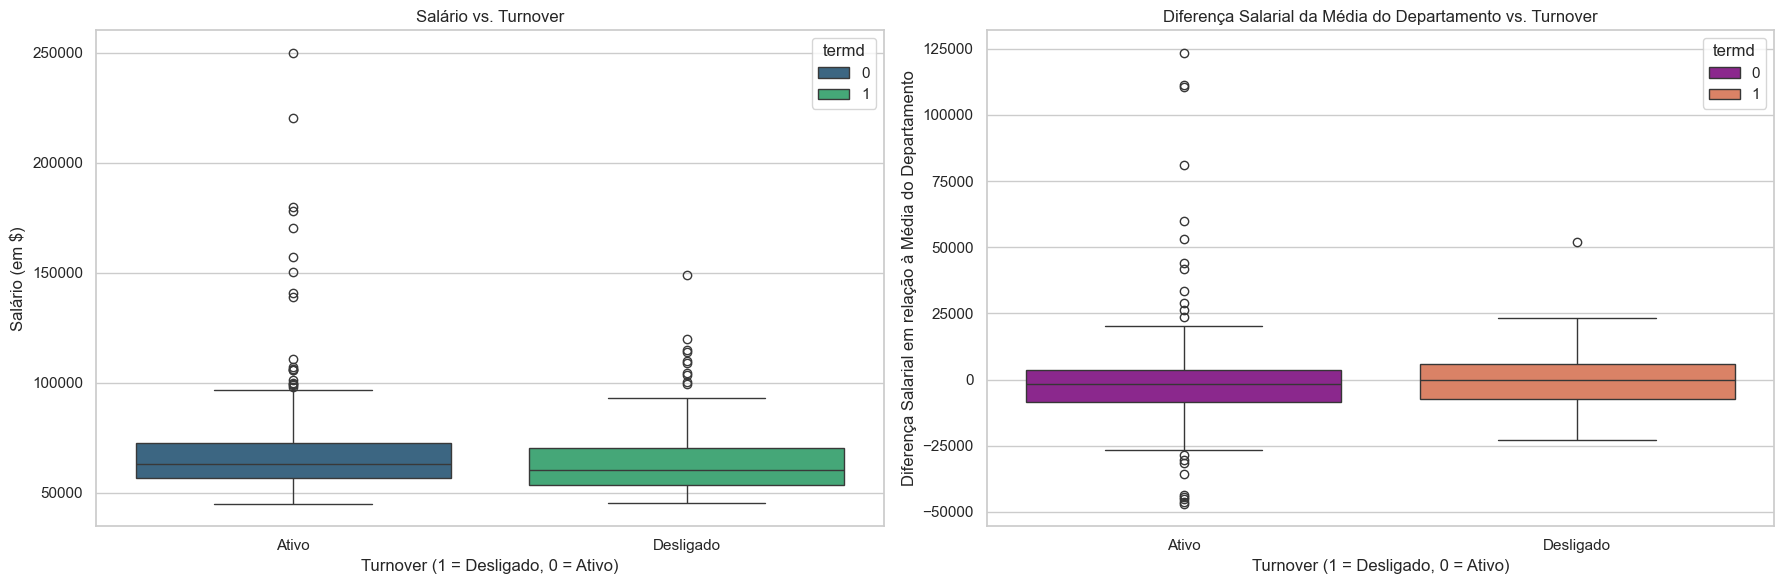

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot para comparar os salários entre funcionários desligados e ativos
sns.boxplot(data=df4, x='termd', y='salary', palette="viridis",hue='termd', ax=axes[0])
axes[0].set_title("Salário vs. Turnover")
axes[0].set_xlabel("Turnover (1 = Desligado, 0 = Ativo)")
axes[0].set_ylabel("Salário (em $)")
axes[0].set_xticks([0, 1])
axes[0].set_xticks([0, 1], ['Ativo', 'Desligado'])

# Calcular a média e mediana salários por tipo de turnover
absences_by_turnover = df4.groupby('termd')['salary'].agg(['mean', 'median', 'std'])
print(absences_by_turnover)

# Calcular correlação entre salario e turnover
correlation = df4['salary'].corr(df4['termd'])
print(f'Correlação entre salario e turnover: {correlation:.2f}')

# Boxplot de Diferença Salarial em relação à Média do Departamento vs. Turnover
sns.boxplot(data=df4, x='termd', y='salary_from_mean', hue='termd', palette="plasma", ax=axes[1])
axes[1].set_title("Diferença Salarial da Média do Departamento vs. Turnover")
axes[1].set_xlabel("Turnover (1 = Desligado, 0 = Ativo)")
axes[1].set_ylabel("Diferença Salarial em relação à Média do Departamento")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Ativo', 'Desligado'])

# Calcular a média e mediana Diferença Salarial em relação à Média do Departamento por tipo de turnover
aux = df4.groupby('termd')['salary_from_mean'].agg(['mean', 'median', 'std'])
print(aux)

# Calcular correlação entre Diferença Salarial em relação à Média do Departamento e turnover
correlation = df4['salary_from_mean'].corr(df4['termd'])
print(f'Correlação entre Diferença Salarial em relação à Média do Departamento e turnover: {correlation:.2f}')

plt.tight_layout()  # Ajuste para evitar sobreposição
plt.show()


### 4.2.4 Funcionarios de cargos mais elevados tendem a ter menos turnovers
Existem mais turnover em cargos mais altos

position_id
30    1.000000
29    1.000000
2     0.666667
8     0.600000
27    0.500000
23    0.500000
20    0.456140
18    0.384615
19    0.379562
24    0.333333
21    0.333333
9     0.250000
13    0.250000
15    0.200000
3     0.148148
26    0.000000
22    0.000000
28    0.000000
25    0.000000
1     0.000000
17    0.000000
14    0.000000
12    0.000000
11    0.000000
10    0.000000
7     0.000000
6     0.000000
5     0.000000
4     0.000000
16    0.000000
Name: termd, dtype: float64


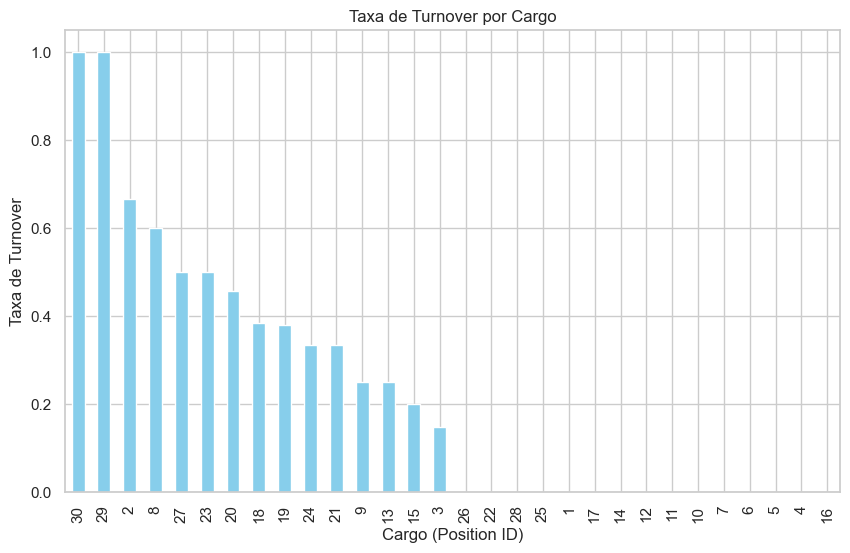

In [75]:
# Calcular a taxa de turnover por cargo
turnover_by_position = df4.groupby('position_id')['termd'].mean().sort_values(ascending=False)

# Visualizar a taxa de turnover por cargo
print(turnover_by_position)

# Plotando a taxa de turnover por cargo
plt.figure(figsize=(10, 6))
turnover_by_position.plot(kind='bar', color='skyblue')
plt.title('Taxa de Turnover por Cargo')
plt.xlabel('Cargo (Position ID)')
plt.ylabel('Taxa de Turnover')
plt.show()



### 4.2.5 Funcionarios com mais faltas tendem a ter mais turnovers
Verdade, porém é uma diferença baixa

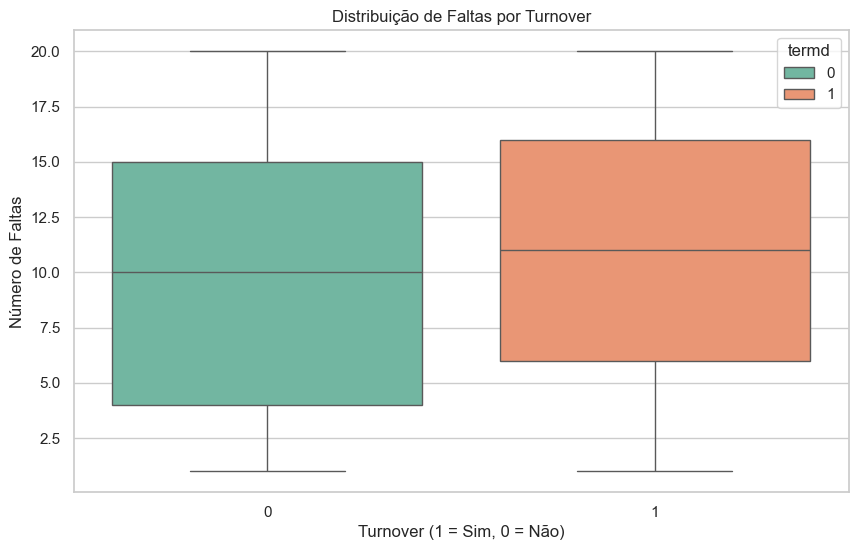

            mean  median       std
termd                             
0       9.830918    10.0  5.846367
1      11.048077    11.0  5.808230
Correlação entre número de faltas e turnover: 0.10


In [76]:
# Verifique a distribuição de faltas entre turnover = 1 e turnover = 0
plt.figure(figsize=(10, 6))
sns.boxplot(x='termd', y='absences', data=df4, hue='termd', palette='Set2')
plt.title('Distribuição de Faltas por Turnover')
plt.xlabel('Turnover (1 = Sim, 0 = Não)')
plt.ylabel('Número de Faltas')
plt.show()

# Calcular a média e mediana de faltas por tipo de turnover
aux = df4.groupby('termd')['absences'].agg(['mean', 'median', 'std'])
print(aux)

# Calcular correlação entre número de faltas e turnover
correlation = df4['absences'].corr(df4['termd'])
print(f'Correlação entre número de faltas e turnover: {correlation:.2f}')

### 4.2.6. Funcionarios casados tendem a ter menos turnover
A taxa de turnover para casados é maior, mas nada significativo

C:\Users\Pedro\AppData\Local\Temp\ipykernel_2504\1304693503.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=turnover_by_marital_status.index, y=turnover_by_marital_status.values, palette='pastel')


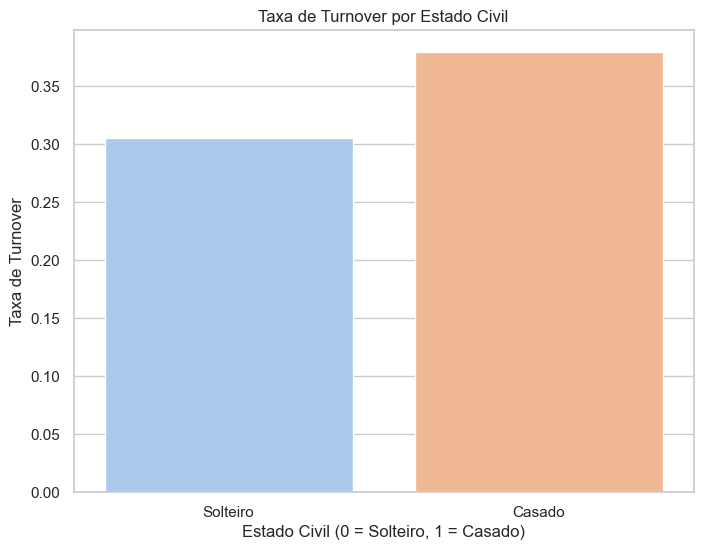

Correlação entre ser casado e turnover: 0.08


In [77]:

# Calcular a taxa média de turnover para funcionários casados e solteiros
turnover_by_marital_status = df4.groupby('married_id')['termd'].mean()

# Plotar a taxa de turnover para funcionários casados e solteiros
plt.figure(figsize=(8, 6))
sns.barplot(x=turnover_by_marital_status.index, y=turnover_by_marital_status.values, palette='pastel')
plt.title('Taxa de Turnover por Estado Civil')
plt.xlabel('Estado Civil (0 = Solteiro, 1 = Casado)')
plt.ylabel('Taxa de Turnover')
plt.xticks([0, 1], ['Solteiro', 'Casado'])
plt.show()

# Calculando a correlação entre estado civil e turnover
correlacao_casado_turnover = df4['married_id'].corr(df4['termd'])
print("Correlação entre ser casado e turnover:", round(correlacao_casado_turnover, 2))


### 4.2.7. Funcionarios com melhores performances tendem a ter menos turnovers
Funcionarios "needs improvement" tem uma taxa de 55% de turnover

C:\Users\Pedro\AppData\Local\Temp\ipykernel_2504\3285644435.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=turnover_by_perf.index, y=turnover_by_perf.values, palette='pastel')


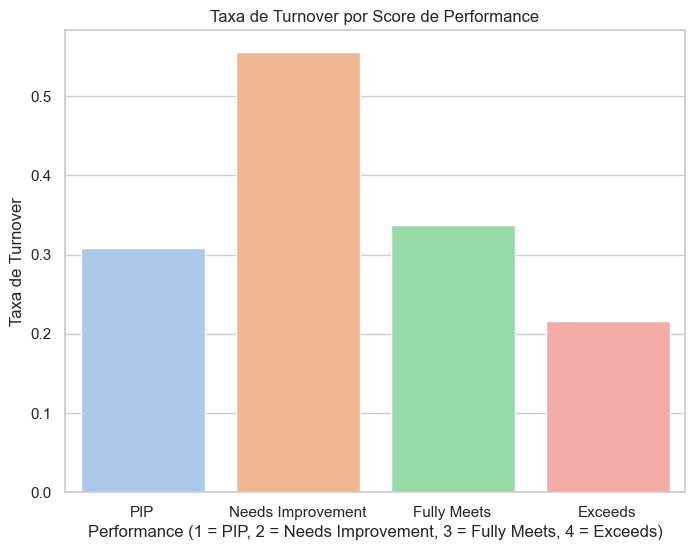

Correlação entre performance e turnover: -0.09


In [78]:

# Calcular a taxa média de turnover para funcionários casados e solteiros
turnover_by_perf = df4.groupby('perf_score_id')['termd'].mean()

# Plotar a taxa de turnover para funcionários casados e solteiros
plt.figure(figsize=(8, 6))
sns.barplot(x=turnover_by_perf.index, y=turnover_by_perf.values, palette='pastel')
plt.title('Taxa de Turnover por Score de Performance')
plt.xlabel('Performance (1 = PIP, 2 = Needs Improvement, 3 = Fully Meets, 4 = Exceeds)')
plt.ylabel('Taxa de Turnover')
plt.xticks([0, 1, 2, 3], ['PIP', 'Needs Improvement', 'Fully Meets', 'Exceeds'])
plt.show()

# Calculando a correlação entre estado civil e turnover
correlacao_perf_turnover = df4['perf_score_id'].corr(df4['termd'])
print("Correlação entre performance e turnover:", round(correlacao_perf_turnover, 2))

### 4.2.8. Funcionarios mais engajados na empresa tendem a ter menos turnovers
Engajamento parece não ser uma metrica que afeta turnover

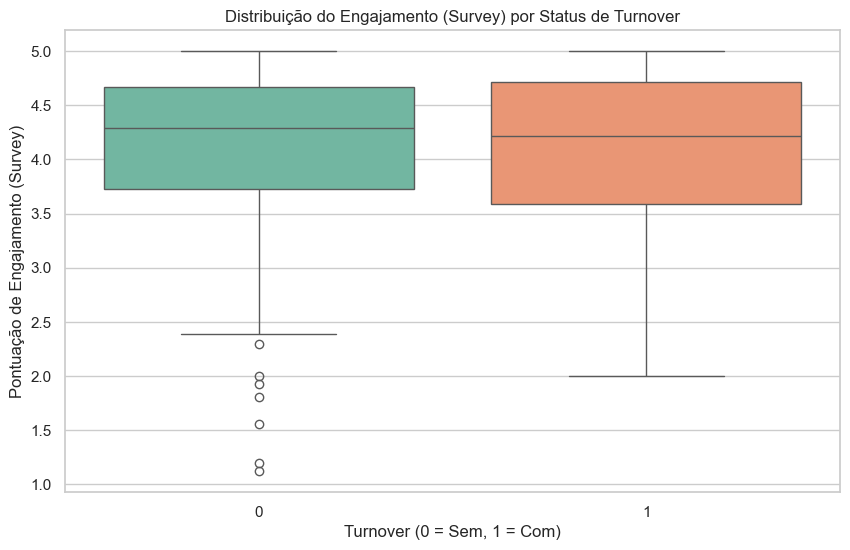

Correlação entre engajamento e turnover: -0.01754287622809002


In [79]:
# Boxplot para comparar o engajamento entre funcionários com e sem turnover
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='termd', y='engagement_survey', hue='termd', palette='Set2', legend=False)
plt.title('Distribuição do Engajamento (Survey) por Status de Turnover')
plt.xlabel('Turnover (0 = Sem, 1 = Com)')
plt.ylabel('Pontuação de Engajamento (Survey)')
plt.show()

# Calculando a correlação entre engajamento e turnover
correlacao_engajamento_turnover = df4['engagement_survey'].corr(df4['termd'])
print("Correlação entre engajamento e turnover:", correlacao_engajamento_turnover)

### 4.2.9. Departamentos diferentes tem o mesmo numero de turnovers
Falso. Existem departamentos com uma taxa mais alta de turnover

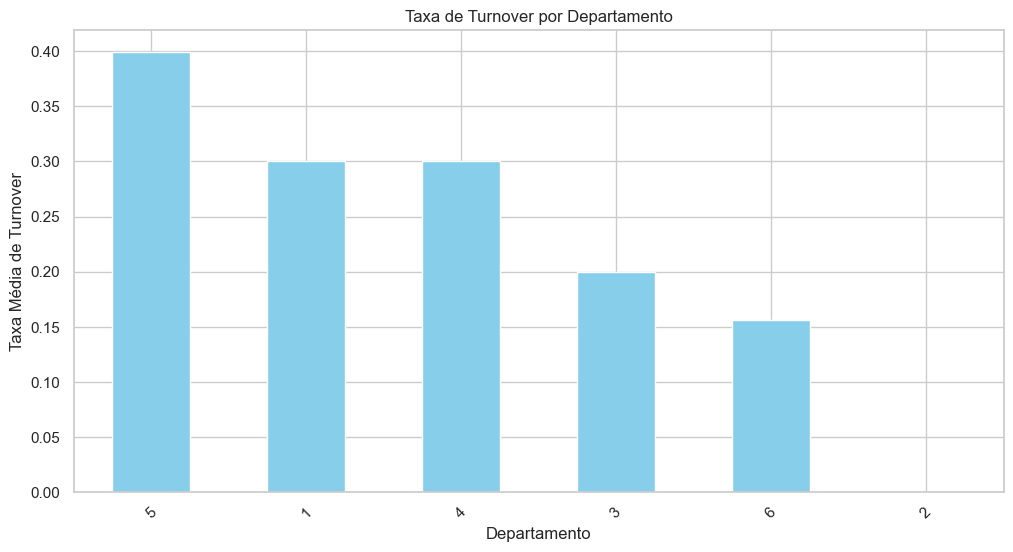

dept_id
5    0.399038
1    0.300000
4    0.300000
3    0.200000
6    0.156250
2    0.000000
Name: termd, dtype: float64


In [80]:
# Calculando a taxa de turnover por departamento
turnover_por_departamento = df4.groupby('dept_id')['termd'].mean().sort_values(ascending=False)

# Visualizando a taxa de turnover por departamento
plt.figure(figsize=(12, 6))
turnover_por_departamento.plot(kind='bar', color='skyblue')
plt.title('Taxa de Turnover por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Taxa Média de Turnover')
plt.xticks(rotation=45)
plt.show()

# Exibindo a taxa de turnover por departamento
print(turnover_por_departamento)


### 4.2.10. Funcionarios avaliados recentemente tem menos turnover
Funcionarios que não recebem avaliação tendem a ter turnover

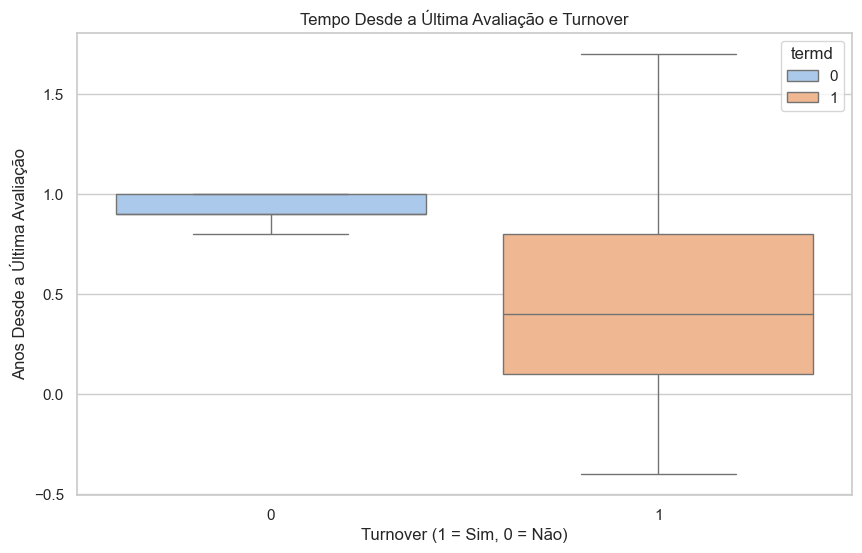

Correlação entre meses desde a última avaliação e turnover: -0.60


In [81]:
# Visualizando o tempo médio desde a última avaliação para funcionários com e sem turnover
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='termd', y='time_since_last_review', hue='termd', palette='pastel')
plt.title('Tempo Desde a Última Avaliação e Turnover')
plt.xlabel('Turnover (1 = Sim, 0 = Não)')
plt.ylabel('Anos Desde a Última Avaliação')
plt.show()

# Calculando a correlação entre meses desde a última avaliação e turnover
correlacao_avaliacao_turnover = df4['time_since_last_review'].corr(df4['termd'])
print(f"Correlação entre meses desde a última avaliação e turnover: {correlacao_avaliacao_turnover:.2f}")

### 4.2.11. Gerentes com mais funcionarios na equipe tendem a ter mais turnovers
Falso, nao parece ter uma correlação muito forte

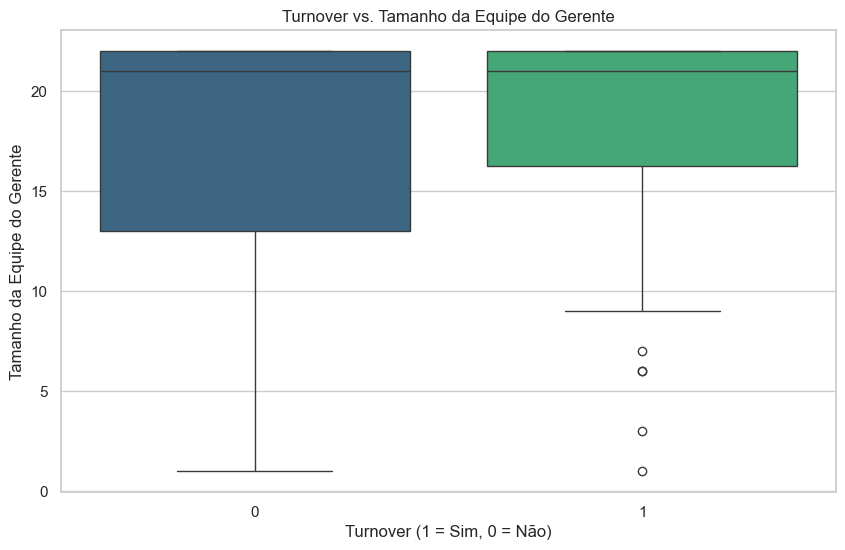

Correlação entre tamanho da equipe do gerente e turnover: 0.13


In [82]:
# Visualizando a relação entre o tamanho da equipe do gerente e o turnover
plt.figure(figsize=(10, 6))
sns.boxplot(data=df4, x='termd', y='manager_workload', hue='termd', palette='viridis', legend=False)
plt.title('Turnover vs. Tamanho da Equipe do Gerente')
plt.xlabel('Turnover (1 = Sim, 0 = Não)')
plt.ylabel('Tamanho da Equipe do Gerente')
plt.show()

# Calculando a correlação entre tamanho da equipe do gerente e turnover
correlacao_manager_turnover = df4['manager_workload'].corr(df4['termd'])
print(f"Correlação entre tamanho da equipe do gerente e turnover: {correlacao_manager_turnover:.2f}")



## 4.3. Análise Multivariada
1. Como visto nas hipoteses, as maiores correlações com **turnover** são: **time_since_last_review** e **serivce_time**

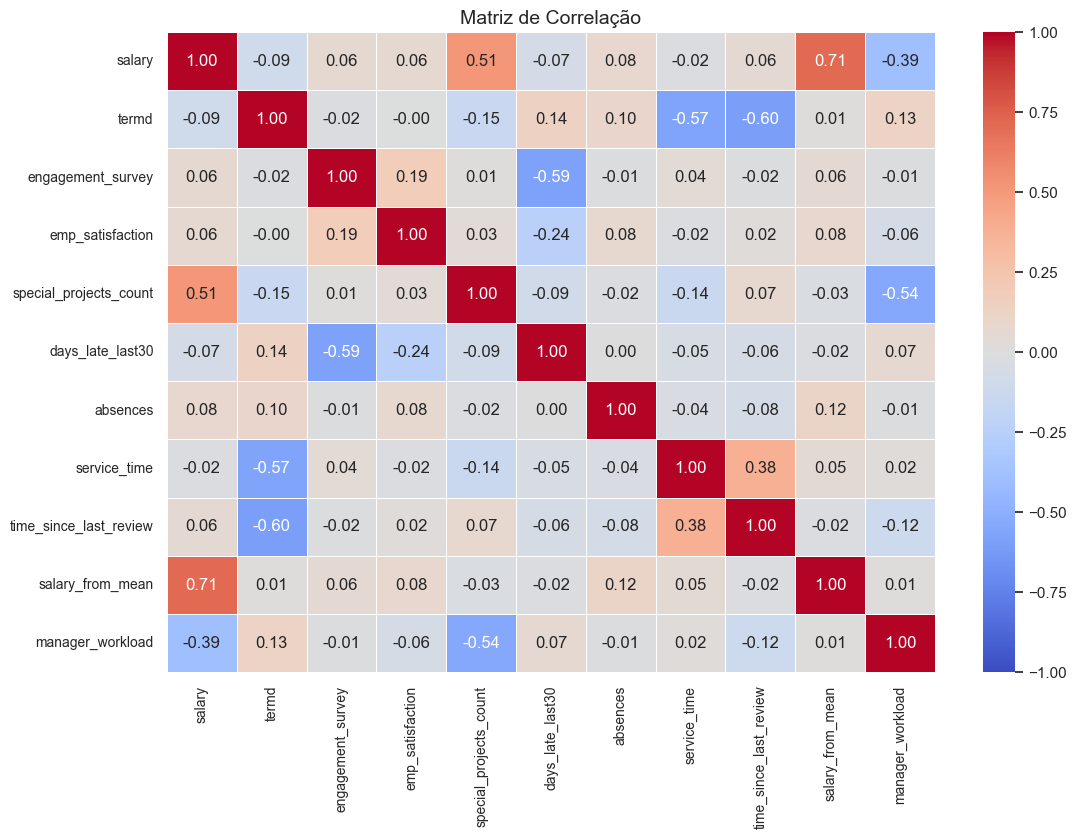

In [83]:
# Selecionar apenas as colunas numéricas (excluindo colunas de texto)
df_numeric = df4.select_dtypes(include=['number'])

# Remover as colunas de identificação (como 'employee_id', 'manager_id', etc.)
cols_to_drop = ['emp_id', 'married_id', 'marital_status_id', 'gender_id', 'emp_status_id', 'dept_id', 'perf_score_id', 'from_diversity_job_fair_id', 'position_id', 'manager_id']  # Adicione outras colunas de ID aqui
df_numeric = df_numeric.drop(columns=cols_to_drop)

# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(12, 8))  # Aumentar o tamanho da figura para dar mais espaço
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, fmt='.2f')

# Ajustar o tamanho da fonte dos números
plt.tick_params(axis='both', which='major', labelsize=10)  # Ajustar o tamanho das legendas

# Ajustar o tamanho da fonte dentro dos quadrados
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Ajusta a margem do gráfico

# Título
plt.title('Matriz de Correlação', fontsize=14)

plt.show()

# 5.0. PREPARAÇÃO DOS DADOS

In [84]:
df5 = df4.copy()

In [85]:
cols_drop = ['emp_id', 'employment_status', 'emp_status_id', 'from_diversity_job_fair_id', 'position', 'sex', 'marital_desc', 'citizen_desc', 
         'hispanic_latino', 'race_desc', 'term_reason', 'department', 'manager_id', 'recruitment_source', 'performance_score', 'engagement_survey', 'emp_satisfaction', 'days_late_last30', 'position_id', 'marital_status_id'] 
df5 = df5.drop(columns=cols_drop)

## Separação em treino e teste

In [86]:
# Separar variáveis
X = df5.drop(columns=['termd'])  # X: features
y = df5['termd']  # y: target

# Separar 10% para teste final, mantendo a proporção das classes
X_temp, X_final_test, y_temp, y_final_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Dividir os 90% restantes em treino e validação (80% treino e 20% validação)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Aplicando SMOTE no conjunto de treino
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)

# Exibir os tamanhos dos conjuntos
print("Tamanho do conjunto de treino SMOTE:", X_train.shape)
print("Tamanho do conjunto de validação:", X_test.shape)
print("Tamanho do conjunto de teste final:", X_final_test.shape)

Tamanho do conjunto de treino SMOTE: (223, 11)
Tamanho do conjunto de validação: (56, 11)
Tamanho do conjunto de teste final: (32, 11)


## 5.1. Transformações

In [87]:
cols_standard = ['service_time', 'salary_from_mean']

cols_minmax = ['salary', 'special_projects_count', 'absences', 'time_since_last_review', 'manager_workload']

In [88]:
# Scalers
sscaler = pp.StandardScaler()
mmscaler = pp.MinMaxScaler()

# Standard
X_train[cols_standard] = sscaler.fit_transform(X_train[cols_standard])
X_test[cols_standard] = sscaler.transform(X_test[cols_standard])
X_final_test[cols_standard] = sscaler.transform(X_final_test[cols_standard])


# Min Max
X_train[cols_minmax] = mmscaler.fit_transform(X_train[cols_minmax])
X_test[cols_minmax] = mmscaler.transform(X_test[cols_minmax])
X_final_test[cols_minmax] = mmscaler.transform(X_final_test[cols_minmax])

## 5.2. Encoders

# 6.0. SELEÇÃO DE FEATURES

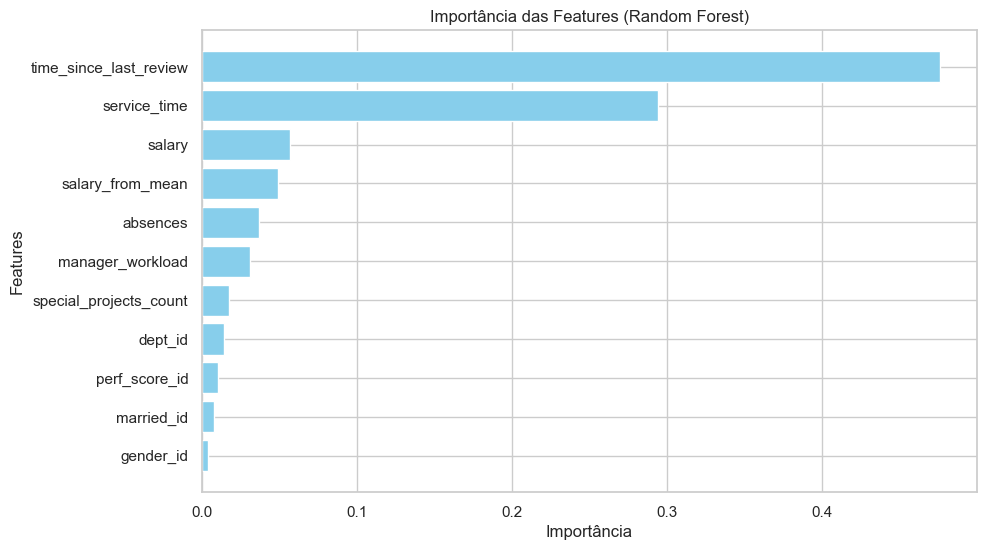

In [89]:
# Treinando o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Obter as importâncias das features
importances = model.feature_importances_
feature_names = X_train.columns

# Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotando as features mais importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Inverter para mostrar do maior para o menor
plt.title('Importância das Features (Random Forest)')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()


In [91]:
x_train = X_train[['time_since_last_review', 'service_time', 'salary']]
x_test = X_test[['time_since_last_review', 'service_time', 'salary']]
x_final_test = X_final_test[['time_since_last_review', 'service_time', 'salary']]

# 7.0. ALGORITMOS DE MACHINE LEARNING

In [92]:
# For Cross Validation
x_full = pd.concat([x_train, x_test])
y_full = pd.concat([y_train, y_test])

# For final test
X_full = pd.concat([x_train, x_test, x_final_test])
Y_full = pd.concat([y_train, y_test, y_final_test])


## 7.1. Logistic Regression

In [93]:
lr_model = LogisticRegression(max_iter=1000)

# Treinar o modelo
lr_model.fit(x_train, y_train)

# Fazer previsões
lr_pred = lr_model.predict(x_test)
lr_prob = lr_model.predict_proba(x_test)[:, 1]

### 7.1.1. Métrica de Avaliação

In [94]:
# Calcular as métricas
metrics = {
    "Accuracy": accuracy_score(y_test, lr_pred),
    "Precision": precision_score(y_test, lr_pred),
    "Recall": recall_score(y_test, lr_pred),
    "F1 Score": f1_score(y_test, lr_pred),
    "ROC AUC": roc_auc_score(y_test, lr_pred),
}

# Criar um DataFrame com as métricas
lr_df = pd.DataFrame(metrics, index=["Random Forest"])
print(lr_df)

               Accuracy  Precision    Recall  F1 Score   ROC AUC
Random Forest  0.785714   0.769231  0.526316     0.625  0.722617


### 7.1.2. Validação Cruzada

In [95]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Validação cruzada
cv_results = cross_validate(
    lr_model,
    x_full,  # Dados de entrada
    y_full,  # Target
    cv=skf,  # Número de folds
    scoring=scoring,  # Métricas avaliadas
    return_train_score=False  # Apenas avaliação no conjunto de validação
)

cv_metrics = {
    "Accuracy": [cv_results['test_accuracy'].mean()],
    "Precision": [cv_results['test_precision'].mean()],
    "Recall": [cv_results['test_recall'].mean()],
    "F1 Score": [cv_results['test_f1'].mean()],
    "ROC AUC": [cv_results['test_roc_auc'].mean()],
}

lr_cv_df = pd.DataFrame(cv_metrics, index=["Logistic Regression"])
print(lr_cv_df)

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression   0.83461   0.821303  0.642105  0.716532  0.904078


## 7.2. Decision Tree 

In [96]:
dt_model = DecisionTreeClassifier(random_state=42)

# Treinar o modelo
dt_model.fit(x_train, y_train)

# Fazer previsões
dt_pred = dt_model.predict(x_test)
dt_proba = dt_model.predict_proba(x_test)[:, 1]

### 7.2.1. Métrica de Avaliação

In [97]:
# Calcular as métricas
metrics = {
    "Accuracy": accuracy_score(y_test, dt_pred),
    "Precision": precision_score(y_test, dt_pred),
    "Recall": recall_score(y_test, dt_pred),
    "F1 Score": f1_score(y_test, dt_pred),
    "ROC AUC": roc_auc_score(y_test, dt_pred),
}

# Criar um DataFrame com as métricas
dt_df = pd.DataFrame(metrics, index=["Decision Tree"])
print(dt_df)

               Accuracy  Precision    Recall  F1 Score   ROC AUC
Decision Tree  0.964286        1.0  0.894737  0.944444  0.947368


### 7.2.2. Validação Cruzada

In [98]:
# Validação cruzada
cv_results = cross_validate(
    dt_model,
    x_full,  # Dados de entrada
    y_full,  # Target
    cv=skf,  # Número de folds
    scoring=scoring,  # Métricas avaliadas
    return_train_score=False  # Apenas avaliação no conjunto de validação
)

cv_metrics = {
    "Accuracy": [cv_results['test_accuracy'].mean()],
    "Precision": [cv_results['test_precision'].mean()],
    "Recall": [cv_results['test_recall'].mean()],
    "F1 Score": [cv_results['test_f1'].mean()],
    "ROC AUC": [cv_results['test_roc_auc'].mean()],
}

dt_cv_df = pd.DataFrame(cv_metrics, index=["Decision Tree"])
print(dt_cv_df)

               Accuracy  Precision    Recall  F1 Score   ROC AUC
Decision Tree  0.932013   0.904594  0.891228  0.892125  0.921361


## 7.3. Random Forest

In [99]:
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo
rf_model.fit(x_train, y_train)

# Fazer previsões
rf_pred = rf_model.predict(x_test)
rf_proba = rf_model.predict_proba(x_test)[:, 1]

### 7.3.1. Métrica de Avaliação

In [100]:
# Calcular as métricas
metrics = {
    "Accuracy": accuracy_score(y_test, rf_pred),
    "Precision": precision_score(y_test, rf_pred),
    "Recall": recall_score(y_test, rf_pred),
    "F1 Score": f1_score(y_test, rf_pred),
    "ROC AUC": roc_auc_score(y_test, rf_pred),
}

# Criar um DataFrame com as métricas
rf_df = pd.DataFrame(metrics, index=["Random Forest"])
print(rf_df)

               Accuracy  Precision    Recall  F1 Score   ROC AUC
Random Forest  0.964286        1.0  0.894737  0.944444  0.947368


### 7.3.2. Validação Cruzada

In [101]:
# Validação cruzada
cv_results = cross_validate(
    rf_model,
    x_full,  # Dados de entrada
    y_full,  # Target
    cv=skf,  # Número de folds
    scoring=scoring,  # Métricas avaliadas
    return_train_score=False  # Apenas avaliação no conjunto de validação
)

cv_metrics = {
    "Accuracy": [cv_results['test_accuracy'].mean()],
    "Precision": [cv_results['test_precision'].mean()],
    "Recall": [cv_results['test_recall'].mean()],
    "F1 Score": [cv_results['test_f1'].mean()],
    "ROC AUC": [cv_results['test_roc_auc'].mean()],
}

rf_cv_df = pd.DataFrame(cv_metrics, index=["Random Forest"])
print(rf_cv_df)

               Accuracy  Precision    Recall  F1 Score   ROC AUC
Random Forest  0.946234   0.966471  0.869591  0.912138  0.977663


## 7.4. Gradient Boost  

In [102]:
gb_model = GradientBoostingClassifier(random_state=42)

# Treinar o modelo
gb_model.fit(x_train, y_train)

# Fazer previsões
gb_pred = gb_model.predict(x_test)
gb_proba = gb_model.predict_proba(x_test)[:, 1]

### 7.4.1 Métrica de Avaliação

In [103]:
# Calcular as métricas
metrics = {
    "Accuracy": accuracy_score(y_test, gb_pred),
    "Precision": precision_score(y_test, gb_pred),
    "Recall": recall_score(y_test, gb_pred),
    "F1 Score": f1_score(y_test, gb_pred),
    "ROC AUC": roc_auc_score(y_test, gb_pred),
}

# Criar um DataFrame com as métricas
gb_df = pd.DataFrame(metrics, index=["Gradient Boost"])
print(gb_df)

                Accuracy  Precision    Recall  F1 Score   ROC AUC
Gradient Boost  0.946429        1.0  0.842105  0.914286  0.921053


### 7.4.2. Validação Cruzada

In [104]:
# Validação cruzada
cv_results = cross_validate(
    gb_model,
    x_full,  # Dados de entrada
    y_full,  # Target
    cv=skf,  # Número de folds
    scoring=scoring,  # Métricas avaliadas
    return_train_score=False  # Apenas avaliação no conjunto de validação
)

cv_metrics = {
    "Accuracy": [cv_results['test_accuracy'].mean()],
    "Precision": [cv_results['test_precision'].mean()],
    "Recall": [cv_results['test_recall'].mean()],
    "F1 Score": [cv_results['test_f1'].mean()],
    "ROC AUC": [cv_results['test_roc_auc'].mean()],
}

gb_cv_df = pd.DataFrame(cv_metrics, index=["Gradient Boost"])
print(gb_cv_df)

                Accuracy  Precision    Recall  F1 Score   ROC AUC
Gradient Boost  0.953506   0.968363  0.891228  0.922139  0.984092


## 7.5 Results

In [105]:
df_results = pd.concat([lr_cv_df, dt_cv_df, rf_cv_df, gb_cv_df])
df_results

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.834610,0.821303,0.642105,0.716532,0.904078
Decision Tree,0.932013,0.904594,0.891228,0.892125,0.921361
Random Forest,0.946234,0.966471,0.869591,0.912138,0.977663
Gradient Boost,0.953506,0.968363,0.891228,0.922139,0.984092


# 8.0. AJUSTE DE HIPER-PARÂMETROS

In [36]:
# Modelo base
rf = RandomForestClassifier(random_state=42)

# Espaço de hiperparâmetros
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   scoring='recall', n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(x_full, y_full)

# Melhor combinação de parâmetros
print("Melhores parâmetros:", random_search.best_params_)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 156}


In [37]:
rf_model_tuned = RandomForestClassifier(
    max_depth=20,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=8,
    n_estimators=156,
    random_state=42
)
rf_model_tuned.fit(x_train, y_train)

y_pred = rf_model_tuned.predict(x_test)
y_prob = rf_model_tuned.predict_proba(x_test)[:, 1]

# Métricas de avaliação
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))



Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0


## 8.1. Final Test

In [38]:
test_prob = rf_model_tuned.predict_proba(x_final_test)[:, 1]
test_df = pd.DataFrame({
    'Funcionario': x_final_test.index,
    'Resposta': y_final_test,
    'Probabilidade_turnover': test_prob
}).sort_values(by='Probabilidade_turnover', ascending=False)

test_df

,Funcionario,Resposta,Probabilidade_turnover
112,112,1,1.000000
233,233,1,1.000000
280,280,1,1.000000
303,303,1,1.000000
53,53,1,0.999288
188,188,1,0.996154
185,185,1,0.985964
151,151,1,0.983974
218,218,1,0.955807
224,224,1,0.924428


# 9.0 Dataframe com os funcionarios ativos e as probabilidades

In [53]:
# Estime as probabilidades com validação cruzada
probabilidades_cv = cross_val_predict(
    rf_model_tuned, X_full, Y_full, cv=5, method='predict_proba')[:, 1]

# Crie um DataFrame com as estimativas para toda a base
ranking = pd.DataFrame({
    'Funcionario': X_full.index,
    'EmpID': df4['emp_id'],
    'Probabilidade Turnover': np.round(probabilidades_cv, 2),
    'Performance': df4['perf_score_id'],
    'Departamento': df4['department'],
    'Posicao': df4['position'],
    'Tempo Review':df4['time_since_last_review'],
    'Tempo Servico': df4['service_time'],
    'Turnover': df4['termd']}
)



# Criar coluna de prioridade combinada
ranking['Prioridade'] = round((
    ranking['Probabilidade Turnover'] * 0.5 +  # 30% peso para probabilidade de turnover
    ranking['Performance'] * 0.2 +            # 20% peso para desempenho
    ranking['Tempo Review'] * 0.3 # 50% peso para tempo desde a última revisão
),2)

ativos = ranking[ranking['Turnover'] == 0]

# Ordenar pelo critério de prioridade
ativos = ativos.sort_values(by='Prioridade', ascending=False)

In [55]:
ativos.to_csv('../data/ativos.csv')